# Level 3: Introduction to Modeling

We'll be learning how to do one of the coolest parts of data science in this level: modeling. When you collect data, you usually have something that you want to predict based on the other information you collect. There are a few different ways to do this type of prediction, but we'll look at two in particular: $k$-nearest neighbor (KNN) and linear regression. However, there are some things that are generally good to know when modeling; let's cover those and then get into some modeling!

When we're trying to predict a certain variable, we usually call that the *output* variable; the variables we use to predict the variable are typically called *input* variables. One notational note is that prediction is called classification if there are a discrete number of output variables and regression if the output is continuous. Additionally, we usually get a set of data points in which we have collected both the value of the output variable and the values of the input variables. The procedure we use to predict on a new data point will be our *model*, and there are a variety of modeling techniques we could choose from. Lucky for us, there's a Python package named `scikit-learn` that already implements a lot of these for us.

When building a model, we want to train on some high fraction (60 to 80 percent) of these points, and then test it on the remaining points to estimate the model's performance. The reason we want to test on points that we didn't train on is that predicting on points we've already seen before will artificially increase our accuracy; to get a reasonable estimate of how our model will do on unseen data, we should test our model on only data that the training procedure didn't see. This splits results in two datasets: the *training* and the *test* set; as their names imply, the training data is what we train our model on, and the test set is what we test our model on.

To make all of these more concrete, let's apply it to our problem at hand: weather prediction. We collected various weather data on roughly 1000 days including the average temperature on that day, the wind speed that day, the precipitation, and so on. What we want to do is predict the precipitation from the other variables.

Great! Now that we've established the prediction problem we're aiming to solve, let's start looking at our first prediction method: *k-nearest neighbor*. It actually is intuitive; the $k$-nearest neighbor algorithm says that for any new point, we should predict the average of the output values of the $k$ points closest to the new point seen in training. Let's look at this picture to get a better idea:

![Nearest Neighbor Picture](nn.gif)

In this picture, we'll be doing $k$-nearest neighbor, where $k$ = 3. The algorithm then looks at the closest 3 points to the point in question and then decides what to predict. (Here, the algorithm would predict that the point in question has a value of B because the majority of the 3 points closest to the point in question are B.) This algorithm hopefully makes sense now because points should be located near other points that have the same value as themselves.

Now, let's start using our knowledge about the $k$-nearest neighbor algorithm to predict some precipitation! We'll first read in our cleaned up data set from the previous level.

In [4]:
import pandas as pd

data = pd.read_csv('clean_weather_data.csv')
print(data.dtypes)
data[:5]

index                 int64
month                 int64
day                   int64
year                  int64
mean_temperature      int64
max_temperature       int64
min_temperature       int64
dew_point             int64
average_humidity      int64
maximum_humidity      int64
minimum_humidity      int64
precipitation       float64
wind_speed          float64
max_wind_speed      float64
max_gust_speed      float64
dtype: object


,index,month,day,year,mean_temperature,max_temperature,min_temperature,dew_point,average_humidity,maximum_humidity,minimum_humidity,precipitation,wind_speed,max_wind_speed,max_gust_speed
0,0,1,1,2013,33,40,26,22,54,64,44,0,7,15,26
1,1,1,2,2013,28,33,22,11,48,57,39,0,6,15,22
2,2,1,3,2013,28,32,24,14,56,68,43,0,5,13,20
3,3,1,4,2013,34,37,30,19,56,63,48,0,8,18,28
4,4,1,5,2013,37,42,32,19,48,56,39,0,7,17,26


Looks like everything is good with the data; let's now split up the data into training and test sets. `scikit-learn` already provides a function to do this, which means it's easier for us. We'll use 80% of the data as training data. Another thing to note is that it's typical to separate your prediction variable from the rest of the data when modeling, and we'll follow this convention as well.

In [12]:
import sklearn, sklearn.cross_validation

input_data = data.drop('precipitation', 1)
output_data = data.precipitation
input_train, input_test, output_train, output_test = sklearn.cross_validation.train_test_split(input_data, output_data, test_size=0.2)

Great! Now, let's fit our first model. We'll use $k$ = 3.

In [13]:
import sklearn.neighbors
knn_model = sklearn.neighbors.KNeighborsRegressor(n_neighbors = 3)
knn_model.fit(input_train, output_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_neighbors=3, p=2, weights='uniform')

Yay, fitting a model using `sklearn` is super simple! How do we know how well our model did? Well, we can define a function (typically called a *loss function* among data nerds) that says how well you did given what the true value is and what your prediction was. For example, let's say we predicted $\hat{y}$ for a case that had a true value of $y$; one common loss function for regression is $(y - \hat{y})^2$. To see whether we did well, we can compare $\sum_{i = 1}^{n}{(y_i - \hat{y_i})^2}$ to $\sum_{i = 1}^{n}{(y_i - \bar{y})^2}$ where $n$ is the number of data points we have; all this really means is adding up the loss for each individual data point. The second term is equivalent to predicting the average for every case, and if the first term is significantly less, we did much better than just guessing the average. Hopefully we did well, let's find out!

In [30]:
knn_predictions = knn_model.predict(input_train)
sum_of_squares_knn = sum((knn_predictions - output_train) ** 2)
average_output = sum(output_train) / len(output_train)
sum_of_squares_average = sum((average_output - output_train) ** 2)
print("Guessing the average would give %f loss, but we got %f loss, go us!" % (sum_of_squares_average, sum_of_squares_knn))
print("We managed to explain %f%% of the variation in the data!" % (100 * (sum_of_squares_average - sum_of_squares_knn)/sum_of_squares_average))

Guessing the average would give 110.750180 loss, but we got 53.743589 loss, go us!
We managed to explain 51.473136% of the variation in the data!


Cool, we managed to fit and analyze our first model. Let's move on to linear regression.

Let's first think about predicting an output variable with only one input variable. The basic idea of linear regression is that you can aim to fit a straight line through the scatterplot, like so:

![Linear Regression](linear-regression.png)

It turns out that you can generalize this to predicting one variable using multiple variables. Let's see how we can put this into code using `sklearn`.

In [33]:
import sklearn.linear_model

linear_model = sklearn.linear_model.LinearRegression()
linear_model.fit(input_train, output_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Yup, KNN wasn't a special case, `sklearn` just makes things that easy. Let's see how we do.

In [34]:
linear_predictions = linear_model.predict(input_train)
sum_of_squares_knn = sum((linear_predictions - output_train) ** 2)
print("Guessing the average would give %f loss, but we got %f loss, go us!" % (sum_of_squares_average, sum_of_squares_knn))
print("We managed to explain %f%% of the variation in the data!" % (100 * (sum_of_squares_average - sum_of_squares_knn)/sum_of_squares_average))

Guessing the average would give 110.750180 loss, but we got 80.230525 loss, go us!
We managed to explain 27.557206% of the variation in the data!


As it turns out, linear regression didn't do as well as the more simplistic KNN algorithm. One of the key ideas in data science is that you have to explore which models are best to use with your data. For fun, let's see how the two models compare by plotting the true value and the predicted value.

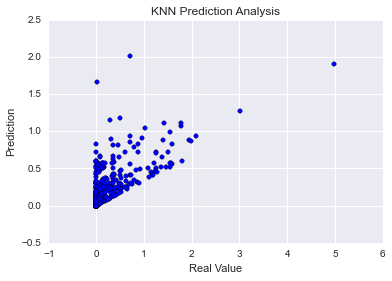

In [36]:
%matplotlib inline
import seaborn as sns

sns.plt.scatter(output_train, knn_predictions)
sns.plt.title('KNN Prediction Analysis')
sns.plt.xlabel('Real Value')
sns.plt.ylabel('Prediction')

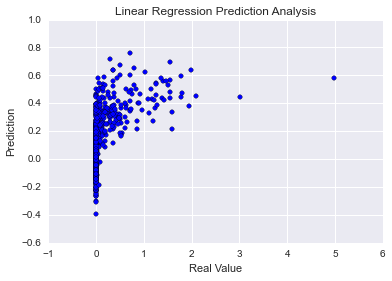

In [37]:
sns.plt.scatter(output_train, linear_predictions)
sns.plt.title('Linear Regression Prediction Analysis')
sns.plt.xlabel('Real Value')
sns.plt.ylabel('Prediction')